In [1]:
import os
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
original_dataset_dir = "Dataset_senyum"
base_output_dir = "Hasil-split-dataset-senyum"
train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")
categories = ['smile', 'non_smile']

for split_dir in [train_dir, val_dir, test_dir]:
    for category in categories:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

random.seed(42)
for category in categories:
    src_dir = os.path.join(original_dataset_dir, category)
    images = os.listdir(src_dir)
    random.shuffle(images)
    total = len(images)
    train_split = int(total * train_ratio)
    val_split = train_split + int(total * val_ratio)

    for i, img in enumerate(images):
        if i < train_split:
            dst = train_dir
        elif i < val_split:
            dst = val_dir
        else:
            dst = test_dir
        shutil.copy(os.path.join(src_dir, img), os.path.join(dst, category, img))

# Menampilkan jumlah data di tiap folder dan kategori
print("\nJumlah data per folder dan kategori:")

total_smile = 0
total_non_smile = 0

for split_dir in [train_dir, val_dir, test_dir]:
    print(f"\nFolder: {os.path.basename(split_dir)}")
    for category in categories:
        category_path = os.path.join(split_dir, category)
        count = len(os.listdir(category_path))
        print(f"  {category}: {count} file")
        
        # Menambahkan ke total
        if category == "smile":
            total_smile += count
        elif category == "non_smile":
            total_non_smile += count

# Menampilkan total data keseluruhan
print("\nTotal keseluruhan:")
print(f"  smile: {total_smile} file")
print(f"  non_smile: {total_non_smile} file")
print(f"  total semua data: {total_smile + total_non_smile} file")




Jumlah data per folder dan kategori:

Folder: train
  smile: 1819 file
  non_smile: 1819 file

Folder: val
  smile: 520 file
  non_smile: 520 file

Folder: test
  smile: 261 file
  non_smile: 261 file

Total keseluruhan:
  smile: 2600 file
  non_smile: 2600 file
  total semua data: 5200 file


In [3]:
batch_sizes = [16, 32]
epochs_list = [20, 30]
learning_rates = [1e-3, 1e-4]
dense_units = [64, 128]
dropouts = [0.75]
target_size = (160, 160)
class_names = ["non_smile", "smile"]


def get_data(batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=15,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=target_size, batch_size=batch_size, class_mode="binary"
    )
    val_gen = val_test_datagen.flow_from_directory(
        val_dir, target_size=target_size, batch_size=batch_size, class_mode="binary"
    )
    test_gen = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False,
    )
    return train_gen, val_gen, test_gen

In [4]:
def create_model(dense, dropout, lr):
    base_model = MobileNetV2(include_top=False, input_shape=(160, 160, 3), weights='imagenet')
    base_model.trainable = True
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(dense, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

results = []
best_val_acc = 0
best_model = None
best_test_generator = None
best_exp_id = -1

combinations = list(itertools.product(batch_sizes, epochs_list, learning_rates, dense_units, dropouts))

for exp_id, (batch_size, epochs, lr, dense, dropout) in enumerate(combinations, start=1):
    print(f"\n Eksperimen #{exp_id}: BS={batch_size}, Epochs={epochs}, LR={lr}, Dense={dense}, Dropout={dropout}")
    train_gen, val_gen, test_gen = get_data(batch_size)
    model = create_model(dense, dropout, lr)

    # Tampilkan struktur model
    print(f"\nArsitektur Model - Eksperimen #{exp_id}")
    model.summary()

    cb = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
    ]

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=cb, verbose=1)

    train_loss, train_acc = model.evaluate(train_gen, verbose=0)
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)

    # Simpan model
    model_path = f"models/experiment_{exp_id}.keras"
    model.save(model_path)

    # Simpan plot akurasi & loss
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'Experiment {exp_id} Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'Experiment {exp_id} Loss')

    plt.tight_layout()
    plt.savefig(f"plots/experiment_{exp_id}_metrics.png")
    plt.close()

    results.append({
        "experiment_id": exp_id,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr,
        "dense_units": dense,
        "dropout": dropout,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "test_loss": test_loss,
        "model_path": model_path
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_test_generator = test_gen
        best_exp_id = exp_id
        model.save("best_model_smile.keras")
        print("Model terbaik diperbarui dan disimpan.")



 Eksperimen #1: BS=16, Epochs=20, LR=0.001, Dense=64, Dropout=0.75
Found 3638 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 522 images belonging to 2 classes.

Arsitektur Model - Eksperimen #1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.6101 - loss: 0.9741 - val_accuracy: 0.7740 - val_loss: 1.5164 - learning_rate: 0.0010
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 4745s 21s/step - accuracy: 0.8124 - loss: 0.4558 - val_accuracy: 0.7837 - val_loss: 1.7746 - learning_rate: 0.0010
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.8727 - loss: 0.3315 - val_accuracy: 0.8721 - val_loss: 0.7303 - learning_rate: 0.0010
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8728 - loss: 0.3236 - val_accuracy: 0.8875 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9061 - loss: 0.2674 - val_accuracy: 0.8769 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9173 - loss: 0.2374 - val_accuracy: 0.9077 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9094 - loss: 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.6751 - loss: 0.8357 - val_accuracy: 0.6654 - val_loss: 1.9494 - learning_rate: 0.0010
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8245 - loss: 0.4580 - val_accuracy: 0.8750 - val_loss: 0.7267 - learning_rate: 0.0010
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8739 - loss: 0.3227 - val_accuracy: 0.8654 - val_loss: 0.7802 - learning_rate: 0.0010
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.8916 - loss: 0.2752 - val_accuracy: 0.6231 - val_loss: 2.8410 - learning_rate: 0.0010
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.9125 - loss: 0.2586 - val_accuracy: 0.9067 - val_loss: 0.3710 - learning_rate: 5.0000e-04
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9258 - loss: 0.2200 - val_accuracy: 0.9019 - val_loss: 0.3866 - learning_rate: 5.0000e-04
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9180 - 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.5761 - loss: 1.0394 - val_accuracy: 0.7500 - val_loss: 0.5375 - learning_rate: 1.0000e-04
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.7387 - loss: 0.6510 - val_accuracy: 0.8317 - val_loss: 0.4500 - learning_rate: 1.0000e-04
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.7908 - loss: 0.5457 - val_accuracy: 0.8769 - val_loss: 0.3770 - learning_rate: 1.0000e-04
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8441 - loss: 0.3973 - val_accuracy: 0.8721 - val_loss: 0.3686 - learning_rate: 1.0000e-04
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.8702 - loss: 0.3517 - val_accuracy: 0.8779 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8773 - loss: 0.3388 - val_accuracy: 0.8606 - val_loss: 0.4010 - learning_rate: 1.0000e-04
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - acc

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.5633 - loss: 1.1215 - val_accuracy: 0.6913 - val_loss: 0.7206 - learning_rate: 1.0000e-04
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.6976 - loss: 0.8148 - val_accuracy: 0.8019 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7948 - loss: 0.5222 - val_accuracy: 0.8308 - val_loss: 0.5020 - learning_rate: 1.0000e-04
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.8247 - loss: 0.4778 - val_accuracy: 0.8731 - val_loss: 0.3512 - learning_rate: 1.0000e-04
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.8553 - loss: 0.3954 - val_accuracy: 0.8404 - val_loss: 0.4858 - learning_rate: 1.0000e-04
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8773 - loss: 0.3243 - val_accuracy: 0.8721 - val_loss: 0.3305 - learning_rate: 1.0000e-04
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - acc

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.6244 - loss: 0.9211 - val_accuracy: 0.5577 - val_loss: 3.5555 - learning_rate: 0.0010
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.8322 - loss: 0.4180 - val_accuracy: 0.6846 - val_loss: 2.7648 - learning_rate: 0.0010
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.8581 - loss: 0.3489 - val_accuracy: 0.7846 - val_loss: 1.2068 - learning_rate: 0.0010
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.8814 - loss: 0.3037 - val_accuracy: 0.8740 - val_loss: 0.5039 - learning_rate: 0.0010
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.8970 - loss: 0.2853 - val_accuracy: 0.8990 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.9153 - loss: 0.2611 - val_accuracy: 0.9029 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.9168 - loss: 0.

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.6209 - loss: 0.9166 - val_accuracy: 0.8019 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8378 - loss: 0.4039 - val_accuracy: 0.6500 - val_loss: 4.3570 - learning_rate: 0.0010
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8671 - loss: 0.3347 - val_accuracy: 0.8010 - val_loss: 1.1459 - learning_rate: 0.0010
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8941 - loss: 0.2951 - val_accuracy: 0.8808 - val_loss: 0.6516 - learning_rate: 5.0000e-04
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9119 - loss: 0.2352 - val_accuracy: 0.8942 - val_loss: 0.5596 - learning_rate: 5.0000e-04
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9225 - loss: 0.2376 - val_accuracy: 0.9163 - val_loss: 0.3685 - learning_rate: 5.0000e-04
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.927

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.5283 - loss: 1.1675 - val_accuracy: 0.6327 - val_loss: 0.7574 - learning_rate: 1.0000e-04
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.6863 - loss: 0.7631 - val_accuracy: 0.6760 - val_loss: 0.8521 - learning_rate: 1.0000e-04
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.7701 - loss: 0.5544 - val_accuracy: 0.8077 - val_loss: 0.5800 - learning_rate: 1.0000e-04
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8098 - loss: 0.4920 - val_accuracy: 0.8423 - val_loss: 0.4675 - learning_rate: 1.0000e-04
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.8456 - loss: 0.4266 - val_accuracy: 0.8692 - val_loss: 0.3353 - learning_rate: 1.0000e-04
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.8735 - loss: 0.3404 - val_accuracy: 0.8856 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - acc

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.5819 - loss: 1.0495 - val_accuracy: 0.7115 - val_loss: 0.5971 - learning_rate: 1.0000e-04
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.6998 - loss: 0.7817 - val_accuracy: 0.8269 - val_loss: 0.4296 - learning_rate: 1.0000e-04
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7945 - loss: 0.5605 - val_accuracy: 0.8654 - val_loss: 0.3185 - learning_rate: 1.0000e-04
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 2778s 12s/step - accuracy: 0.8400 - loss: 0.4358 - val_accuracy: 0.8490 - val_loss: 0.3446 - learning_rate: 1.0000e-04
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8691 - loss: 0.3578 - val_accuracy: 0.8394 - val_loss: 0.4791 - learning_rate: 1.0000e-04
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.8771 - loss: 0.3389 - val_accuracy: 0.8625 - val_loss: 0.3867 - learning_rate: 5.0000e-05

 Eksperimen #9: BS=32, Epochs=20, LR=0.001, Dense=64, D

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.6596 - loss: 0.8407 - val_accuracy: 0.7462 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.8419 - loss: 0.3992 - val_accuracy: 0.8721 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.8839 - loss: 0.3095 - val_accuracy: 0.8683 - val_loss: 0.5879 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9029 - loss: 0.2454 - val_accuracy: 0.8913 - val_loss: 0.4769 - learning_rate: 0.0010
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9180 - loss: 0.2308 - val_accuracy: 0.8769 - val_loss: 0.7501 - learning_rate: 0.0010
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9199 - loss: 0.1985 - val_accuracy: 0.8923 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.9287 - loss: 0.

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6143 - loss: 1.0038 - val_accuracy: 0.5779 - val_loss: 3.5019 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8401 - loss: 0.4034 - val_accuracy: 0.7817 - val_loss: 1.4336 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8902 - loss: 0.3068 - val_accuracy: 0.9067 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9007 - loss: 0.2757 - val_accuracy: 0.8865 - val_loss: 0.9276 - learning_rate: 0.0010
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9013 - loss: 0.2537 - val_accuracy: 0.8913 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9248 - loss: 0.1968 - val_accuracy: 0.9067 - val_loss: 0.4476 - learning_rate: 5.0000e-04
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9329 - loss

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.5466 - loss: 1.2101 - val_accuracy: 0.6115 - val_loss: 0.9641 - learning_rate: 1.0000e-04
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.6946 - loss: 0.8143 - val_accuracy: 0.7077 - val_loss: 0.8894 - learning_rate: 1.0000e-04
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.7782 - loss: 0.5782 - val_accuracy: 0.8288 - val_loss: 0.4223 - learning_rate: 1.0000e-04
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.8223 - loss: 0.4587 - val_accuracy: 0.8644 - val_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.8459 - loss: 0.3809 - val_accuracy: 0.8779 - val_loss: 0.3871 - learning_rate: 1.0000e-04
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.8743 - loss: 0.3422 - val_accuracy: 0.8606 - val_loss: 0.3734 - learning_rate: 1.0000e-04
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - acc

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.5622 - loss: 1.0189 - val_accuracy: 0.7000 - val_loss: 0.5626 - learning_rate: 1.0000e-04
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.7163 - loss: 0.7167 - val_accuracy: 0.7260 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7742 - loss: 0.5716 - val_accuracy: 0.7962 - val_loss: 0.6142 - learning_rate: 1.0000e-04
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.8481 - loss: 0.3972 - val_accuracy: 0.8279 - val_loss: 0.5463 - learning_rate: 5.0000e-05
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8655 - loss: 0.3658 - val_accuracy: 0.8798 - val_loss: 0.3503 - learning_rate: 5.0000e-05
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8643 - loss: 0.3448 - val_accuracy: 0.8837 - val_loss: 0.3817 - learning_rate: 5.0000e-05
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - acc

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.6475 - loss: 0.9122 - val_accuracy: 0.7433 - val_loss: 0.7952 - learning_rate: 0.0010
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8615 - loss: 0.3405 - val_accuracy: 0.8404 - val_loss: 0.6597 - learning_rate: 0.0010
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8987 - loss: 0.2608 - val_accuracy: 0.8856 - val_loss: 0.9161 - learning_rate: 0.0010
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.8877 - loss: 0.2840 - val_accuracy: 0.8510 - val_loss: 0.7748 - learning_rate: 0.0010
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.9268 - loss: 0.2064 - val_accuracy: 0.8365 - val_loss: 0.9607 - learning_rate: 5.0000e-04

 Eksperimen #14: BS=32, Epochs=30, LR=0.001, Dense=128, Dropout=0.75
Found 3638 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 522 images belonging to 2 classes.

Arsitektur Model - Eksperimen #14


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.6336 - loss: 0.9898 - val_accuracy: 0.8385 - val_loss: 0.6807 - learning_rate: 0.0010
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.8533 - loss: 0.3798 - val_accuracy: 0.8587 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.8748 - loss: 0.3095 - val_accuracy: 0.8635 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.9128 - loss: 0.2390 - val_accuracy: 0.8760 - val_loss: 0.7156 - learning_rate: 5.0000e-04

 Eksperimen #15: BS=32, Epochs=30, LR=0.0001, Dense=64, Dropout=0.75
Found 3638 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 522 images belonging to 2 classes.

Arsitektur Model - Eksperimen #15


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_14[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 2,306,049 (8.80 MB)

 Non-trainable params: 34,240 (133.75 KB)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.5801 - loss: 1.1258 - val_accuracy: 0.6567 - val_loss: 0.6703 - learning_rate: 1.0000e-04
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.7067 - loss: 0.8081 - val_accuracy: 0.7837 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.7739 - loss: 0.6287 - val_accuracy: 0.8567 - val_loss: 0.4731 - learning_rate: 1.0000e-04
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.8145 - loss: 0.4708 - val_accuracy: 0.8712 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8519 - loss: 0.3888 - val_accuracy: 0.8740 - val_loss: 0.4040 - learning_rate: 1.0000e-04
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8720 - loss: 0.3670 - val_accuracy: 0.8837 - val_loss: 0.3881 - learning_rate: 1.0000e-04
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - acc

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - accuracy: 0.5470 - loss: 1.1609 - val_accuracy: 0.6471 - val_loss: 0.6854 - learning_rate: 1.0000e-04
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.6904 - loss: 0.7858 - val_accuracy: 0.7433 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.7607 - loss: 0.6267 - val_accuracy: 0.7856 - val_loss: 0.6198 - learning_rate: 1.0000e-04
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.8345 - loss: 0.4438 - val_accuracy: 0.8423 - val_loss: 0.4847 - learning_rate: 1.0000e-04
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.8329 - loss: 0.4428 - val_accuracy: 0.8587 - val_loss: 0.4565 - learning_rate: 1.0000e-04
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.8680 - loss: 0.3399 - val_accuracy: 0.8817 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - acc

In [6]:
df = pd.DataFrame(results)
df.to_csv("tuning_results.csv", index=False)
print("\n Hasil tuning disimpan ke tuning_results.csv")



 Hasil tuning disimpan ke tuning_results.csv



Model terbaik berasal dari Eksperimen #6 dengan val_acc=0.9250
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step


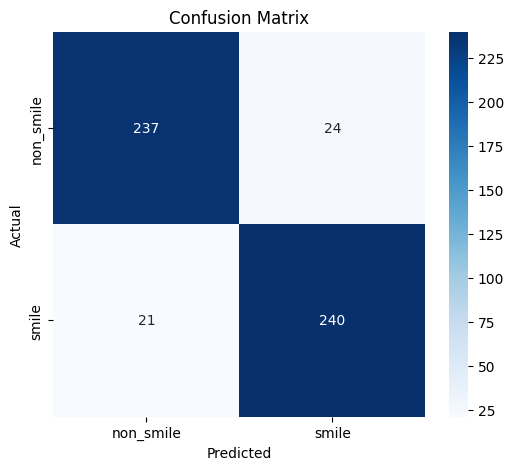


Precision: 0.9091
Recall   : 0.9195
F1 Score : 0.9143

Classification Report:
              precision    recall  f1-score   support

   non_smile       0.92      0.91      0.91       261
       smile       0.91      0.92      0.91       261

    accuracy                           0.91       522
   macro avg       0.91      0.91      0.91       522
weighted avg       0.91      0.91      0.91       522



In [7]:
print(f"\nModel terbaik berasal dari Eksperimen #{best_exp_id} dengan val_acc={best_val_acc:.4f}")

y_probs = best_model.predict(best_test_generator)
y_pred = (y_probs > 0.5).astype(int).flatten()
y_true = best_test_generator.classes

# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
